In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Import datast
df = pd.read_csv('charlie_kirk_comments_cleaned.csv', index_col='id', parse_dates=['date'])
df

,id_post,date,score,subreddit,post,comment
id,,,,,,
1,1,2024-11-01,3,democrats,Remember: Your vote is 100% confidential. No o...,Should be illegal to straight up lie like that...
2,2,2024-11-01,1291,PoliticalHumor,Charlie Kirk falls for fake Garbage Driver Bre...,Brent Terhune trolls the hell out of the Garba...
3,2,2024-11-01,341,PoliticalHumor,Charlie Kirk falls for fake Garbage Driver Bre...,This video on his TikTok has nearly a million ...
4,2,2024-11-01,244,PoliticalHumor,Charlie Kirk falls for fake Garbage Driver Bre...,Nobody ever accused Kirk of being the sharpest...
5,2,2024-11-01,148,PoliticalHumor,Charlie Kirk falls for fake Garbage Driver Bre...,They are upset that they got called garbage by...
...,...,...,...,...,...,...
8052,205,2025-10-15,1,politics,JB Pritzker Compares Trump’s ICE Crackdown to ...,So you believe they will eventually stop bothe...
8053,205,2025-10-15,1,politics,JB Pritzker Compares Trump’s ICE Crackdown to ...,Your go-to example actually did get a hearing ...
8054,205,2025-10-15,1,politics,JB Pritzker Compares Trump’s ICE Crackdown to ...,"Hahahahahha, yeah, they also did a great job i..."


### Volume Over Time

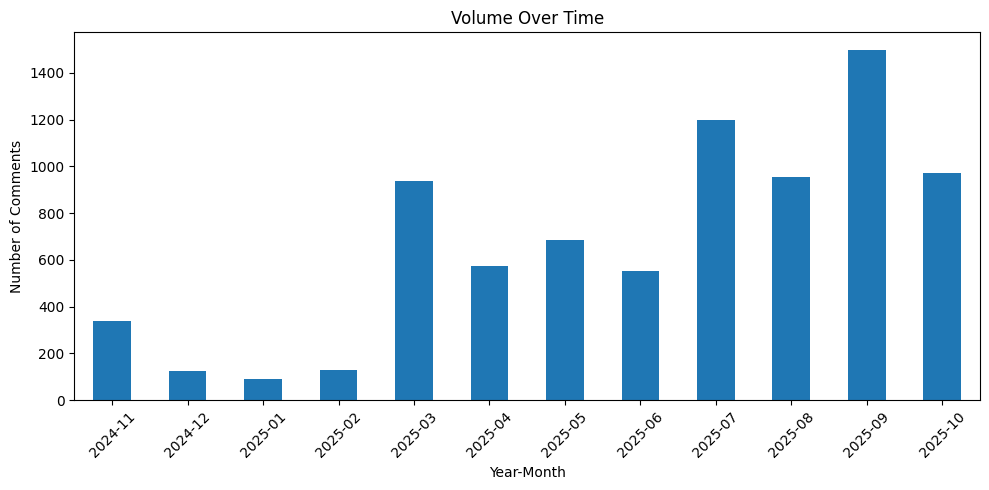

In [22]:
df['year_month'] = df['date'].dt.to_period('M').astype(str)
counts = df['year_month'].value_counts().sort_index()

plt.figure(figsize=(10, 5))
counts.plot.bar()
plt.xlabel('Year-Month')
plt.ylabel('Number of Comments')
plt.title("Volume Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Sentiment analysis

In [23]:
# see if gpu accel is on
import torch
print(torch.cuda.is_available())       # True = working
print(torch.cuda.get_device_name(0))   # Your GPU name

True
NVIDIA GeForce RTX 5070


In [29]:
from transformers import pipeline

# Added truncation to avoid exceedint the token limit. The first part of the comment should capture the essen

# --- 1. Siebert RoBERTa sentiment
siebert_sentiment = pipeline("sentiment-analysis", model="siebert/sentiment-roberta-large-english", truncation=True)
result_siebert = siebert_sentiment("I love this!")
print("siebert/sentiment-roberta-large-english:", result_siebert)

# --- 2. BERTweet sentiment
bertweet_sentiment = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis", truncation=True)
result_bertweet = bertweet_sentiment("I love this!")
print("finiteautomata/bertweet-base-sentiment-analysis:", result_bertweet)

# --- 3. CardiffNLP Twitter RoBERTa sentiment
cardiff_sentiment = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment-latest", max_length=512, truncation=True)
result_cardiff = cardiff_sentiment("I love this!")
print("cardiffnlp/twitter-roberta-base-sentiment-latest:", result_cardiff)



Device set to use cuda:0


siebert/sentiment-roberta-large-english: [{'label': 'POSITIVE', 'score': 0.9988656044006348}]


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0
Device set to use cuda:0


finiteautomata/bertweet-base-sentiment-analysis: [{'label': 'POS', 'score': 0.9924272894859314}]


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0


cardiffnlp/twitter-roberta-base-sentiment-latest: [{'label': 'positive', 'score': 0.9802452921867371}]


In [32]:
def get_sentiment(text, model_pipeline):
    result = model_pipeline(text)[0]
    return result['label'], result['score']

# Post pipeline
df_post = df.reset_index().loc[:,['id_post','post']].drop_duplicates().set_index('id_post')

df_post['siebert_label'], df_post['siebert_score'] = zip(*df_post['post'].apply(lambda x: get_sentiment(x, siebert_sentiment)))
df_post['bertweet_label'], df_post['bertweet_score'] = zip(*df_post['post'].apply(lambda x: get_sentiment(x, bertweet_sentiment)))
df_post['cardiff_label'], df_post['cardiff_score'] = zip(*df_post['post'].apply(lambda x: get_sentiment(x, cardiff_sentiment)))

display(df_post)
df.to_csv('charlie_kirk_posts_tagged.csv')

,post,siebert_label,siebert_score,bertweet_label,bertweet_score,cardiff_label,cardiff_score
id_post,,,,,,,
1,Remember: Your vote is 100% confidential. No o...,POSITIVE,0.995967,NEU,0.741308,neutral,0.658229
2,Charlie Kirk falls for fake Garbage Driver Bre...,NEGATIVE,0.999026,NEG,0.935195,negative,0.742689
3,Charlie Kirk - We need 3 million Trump voters ...,POSITIVE,0.997020,POS,0.603049,neutral,0.661165
4,Reported by Charlie Kirk in PA,POSITIVE,0.981004,NEU,0.966320,neutral,0.940062
5,Most watched streams during the Presidential E...,POSITIVE,0.997311,NEU,0.887336,neutral,0.869098
...,...,...,...,...,...,...,...
201,Trump awards the Medal of Freedom posthumously...,POSITIVE,0.998221,POS,0.641246,neutral,0.684402
202,Trump admin slammed after revoking visas for t...,NEGATIVE,0.999435,NEG,0.873724,negative,0.766752
203,Trump Brags About Rose Garden Renovations at C...,NEGATIVE,0.705800,NEU,0.945478,neutral,0.904282


In [33]:
# Comment pipeline
df['siebert_label'], df['siebert_score'] = zip(*df['comment'].apply(lambda x: get_sentiment(x, siebert_sentiment)))
df['bertweet_label'], df['bertweet_score'] = zip(*df['comment'].apply(lambda x: get_sentiment(x, bertweet_sentiment)))
df['cardiff_label'], df['cardiff_score'] = zip(*df['comment'].apply(lambda x: get_sentiment(x, cardiff_sentiment)))

display(df)
df.to_csv('charlie_kirk_comments_tagged.csv')

,id_post,date,score,subreddit,post,comment,year_month,siebert_label,siebert_score,bertweet_label,bertweet_score,cardiff_label,cardiff_score
id,,,,,,,,,,,,,
1,1,2024-11-01,3,democrats,Remember: Your vote is 100% confidential. No o...,Should be illegal to straight up lie like that...,2024-11,NEGATIVE,0.999483,NEG,0.981502,negative,0.941520
2,2,2024-11-01,1291,PoliticalHumor,Charlie Kirk falls for fake Garbage Driver Bre...,Brent Terhune trolls the hell out of the Garba...,2024-11,POSITIVE,0.998305,NEG,0.668998,negative,0.548198
3,2,2024-11-01,341,PoliticalHumor,Charlie Kirk falls for fake Garbage Driver Bre...,This video on his TikTok has nearly a million ...,2024-11,POSITIVE,0.992450,NEU,0.638176,neutral,0.491072
4,2,2024-11-01,244,PoliticalHumor,Charlie Kirk falls for fake Garbage Driver Bre...,Nobody ever accused Kirk of being the sharpest...,2024-11,NEGATIVE,0.999388,NEG,0.951419,negative,0.804607
5,2,2024-11-01,148,PoliticalHumor,Charlie Kirk falls for fake Garbage Driver Bre...,They are upset that they got called garbage by...,2024-11,NEGATIVE,0.999279,NEG,0.959742,negative,0.928648
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8052,205,2025-10-15,1,politics,JB Pritzker Compares Trump’s ICE Crackdown to ...,So you believe they will eventually stop bothe...,2025-10,NEGATIVE,0.996580,NEG,0.910753,neutral,0.692203
8053,205,2025-10-15,1,politics,JB Pritzker Compares Trump’s ICE Crackdown to ...,Your go-to example actually did get a hearing ...,2025-10,NEGATIVE,0.998147,NEG,0.815059,negative,0.683629
8054,205,2025-10-15,1,politics,JB Pritzker Compares Trump’s ICE Crackdown to ...,"Hahahahahha, yeah, they also did a great job i...",2025-10,NEGATIVE,0.994977,NEG,0.632005,positive,0.477221
